In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [13]:
# plotting defaults
plt.rc('figure', figsize=(20, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Use SAAS data

In [2]:
saas = pd.read_csv('saas.csv')

In [3]:
saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [4]:
saas.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [5]:
saas['Month_Invoiced'] = pd.to_datetime(saas['Month_Invoiced'])
saas = saas.set_index('Month_Invoiced').sort_index()

In [7]:
saas.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


### 1. Split data (train/validate/test) and resample by any period except daily. Aggregate using the sum.

In [8]:
train_size = int(len(saas) * .5)
validate_size = int(len(saas) * .3)
test_size = int(len(saas) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = saas[: train_size]
validate = saas[train_size : validate_end_index]
test = saas[validate_end_index : ]

In [9]:
train = train.resample('D').sum()
validate = validate.resample('D').sum()
test = test.resample('D').sum()

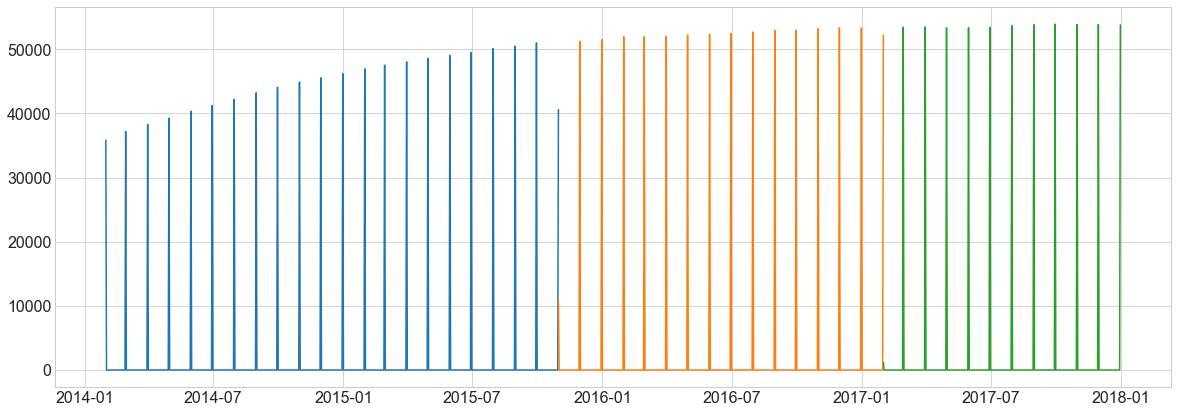

In [14]:
plt.plot(train.index, train.Amount)
plt.plot(validate.index, validate.Amount)
plt.plot(test.index, test.Amount)
plt.show()

### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
#### Simple Average

#### Moving Average

#### Holt's Linear Trend Model

#### Based on previous year/month/etc., this is up to you.